In [9]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
# from skimage.io import imread, imshow
# from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
# from skimage import color, exposure, transform
# from skimage.exposure import equalize_hist

In [26]:
plt.rcParams['image.cmap'] = 'gray'

# ЛАБОРАТОРНА РОБОТА №2. Частотні методи обробки зображень
Михайло Корешков, ФІ-91

## 0. Загальний фільтр

In [46]:
# "розширення для спектру з метою уникнення спотворень 
# пов’язаних із виникненням ефекту інтерференції в
# суміжних періодах."
def paddedsize(shape):
    return 2*np.array(shape)

def dftfilt(img, H):
    # частотний образ зображення. 
    # для зручності відображення та для сумісності з фільтрами, виконуємо fftshift
    #   fftshift ділить зображення на 4 рівні частини та міняє їх місцями по діагоналі.
    #   ця операція зсуває нулі частот до центру зображення, що дозволяє більш явно проявити симетрію частотного образу 
    #    та, в результаті, зручніше писати формули для фільтрів. 
    F = np.fft.fftshift(np.fft.fft2(img, paddedsize(img.shape)))
    if F.shape != H.shape:
        raise ValueError("paddedsize(img.shpe) != H.shape")
    # застовусання фільтру in a frequency domain
    G = F * H   # поелементне множення
    # зворотнє перетворення фур'є - назад до space domain.
    # в загальному випадку перетворення комплексне, тому беремо лише дійсну частину.
    #   не забуваємо також виконати операцію, обернену до fftshift  
    g = np.real(np.fft.ifft2(np.fft.ifftshift(G)))
    # повертаємо початкові розміри зображення
    g = g[0:img.shape[0], 0:img.shape[1]] 

    return g, np.log(1+np.abs(F)), H, np.log(1+np.abs(G))

## 1. Побудова фільтрів

In [147]:
# Ідеальний НЧ фільтр: відсікає всі частоти величини більше D0
def ideal_lowpass(D0, shape):
    d02 = D0*D0
    m,n = shape
    U,V = np.meshgrid(np.arange(m), np.arange(n), sparse=True)
    H = ( np.square(U-m/2) + np.square(V-n/2) <= d02 ).astype(float)
    return H

# Ідеальний ВЧ фільтр: відсікає всі частоти величини менше D0
def ideal_highpass(D0, shape):
    d02 = D0*D0
    m,n = shape
    U,V = np.meshgrid(np.arange(m), np.arange(n), sparse=True)
    H = ( np.square(U-m/2) + np.square(V-n/2) > d02 ).astype(float)
    return H

# НЧ Фільтр Баттерворта порядку K
def butter_lowpass(D0, K, shape):
    d02 = D0*D0
    m,n = shape
    U,V = np.meshgrid(np.arange(m), np.arange(n), sparse=True)
    D2 = np.square(U-m/2) + np.square(V-n/2)
    H = np.float_power(1 + np.float_power( D2 / d02 , K), -1)
    return H
    
def gauss_lowpass(D0, shape):
    d202 = 2*D0*D0
    m,n = shape
    U,V = np.meshgrid(np.arange(m), np.arange(n), sparse=True)
    D2 = np.square(U-m/2) + np.square(V-n/2)
    return np.exp( - D2 / d202 )
    

# ВЧ Фільтр Баттерворта порядку K
def butter_highpass(D0, K, shape):
    d02 = D0*D0
    m,n = shape
    U,V = np.meshgrid(np.arange(m), np.arange(n), sparse=True)
    D2 = np.square(U-m/2) + np.square(V-n/2)
    H = np.float_power(1 + np.float_power( d02 / D2 , K), -1)
    return H

# ВЧ Фільтр Лапласа
def laplace_highpass(shape):
    m,n = shape
    U,V = np.meshgrid(np.arange(m), np.arange(n), sparse=True)
    U = U-m/2
    V = V-n/2
    return -(U*U + V*V)

def gauss_highpass(D0, shape):
    d202 = 2*D0*D0
    m,n = shape
    U,V = np.meshgrid(np.arange(m), np.arange(n), sparse=True)
    D2 = np.square(U-m/2) + np.square(V-n/2)
    return 1 - np.exp( - D2 / d202 )

## 2. Обробка зображень

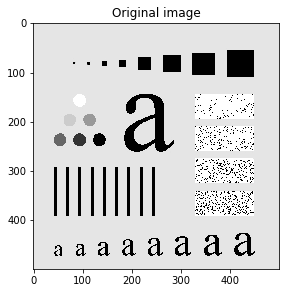

In [133]:
img1 = ski.io.imread('Pic1.jpg')
ski.io.imshow(img1)
plt.title("Original image")

pq = paddedsize(img1.shape)

### 2.1. Низькочастотні фільтри

(<AxesSubplot:title={'center':'Filtered FFT'}>,
 Text(0.5, 1.0, 'Filtered FFT'))

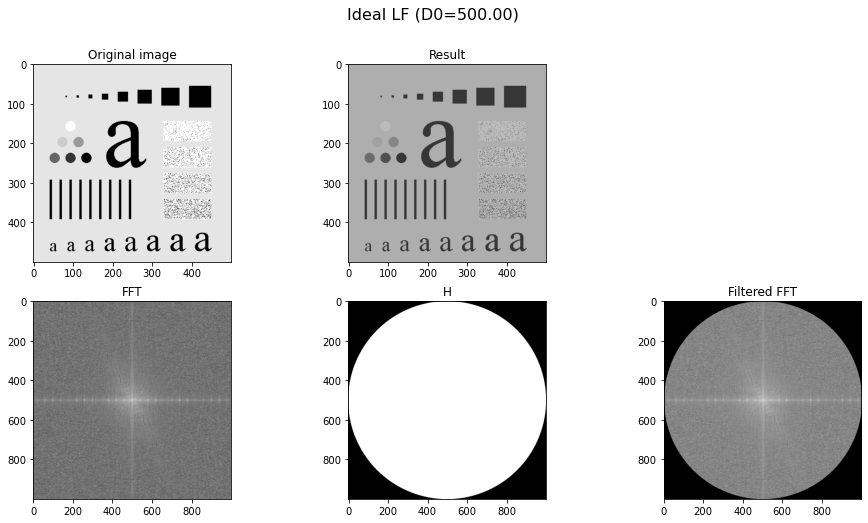

In [72]:
# LF filters
plt.figure(figsize=(16, 8), constrained_layout=False)

d0 = 500
plt.gcf().suptitle(f'Ideal LF (D0={d0:.2f})', fontsize=16)
res = dftfilt(img1, ideal_lowpass(d0, pq))
plt.subplot(231), plt.imshow(img1), plt.title("Original image")
plt.subplot(232), plt.imshow(res[0]), plt.title("Result")
plt.subplot(234), plt.imshow(res[1]), plt.title("FFT")
plt.subplot(235), plt.imshow(res[2]), plt.title("H")
plt.subplot(236), plt.imshow(res[3]), plt.title("Filtered FFT")



(<AxesSubplot:title={'center':'d0 = 10'}>,
 Text(0.5, 1.0, 'd0 = 10'))

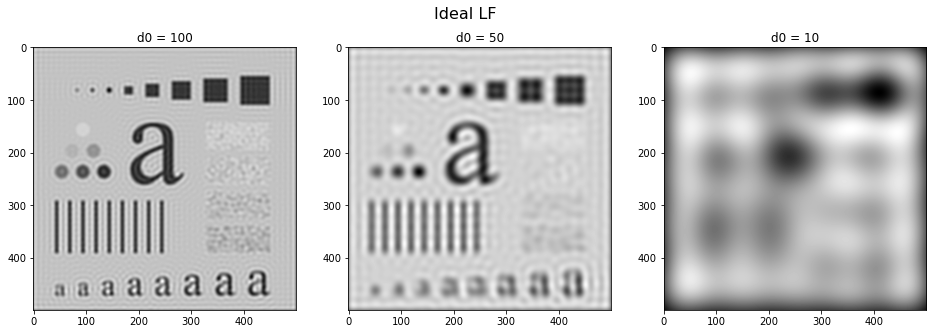

In [77]:
plt.figure(figsize=(16, 5), constrained_layout=False)

plt.gcf().suptitle(f'Ideal LF', fontsize=16)
O,_,_,_ = dftfilt(img1, ideal_lowpass(100, pq))
plt.subplot(131), plt.imshow(O), plt.title("d0 = 100")
O,_,_,_ = dftfilt(img1, ideal_lowpass(50, pq))
plt.subplot(132), plt.imshow(O), plt.title("d0 = 50")
O,_,_,_ = dftfilt(img1, ideal_lowpass(10, pq))
plt.subplot(133), plt.imshow(O), plt.title("d0 = 10")

(<AxesSubplot:title={'center':'Filtered FFT'}>,
 Text(0.5, 1.0, 'Filtered FFT'))

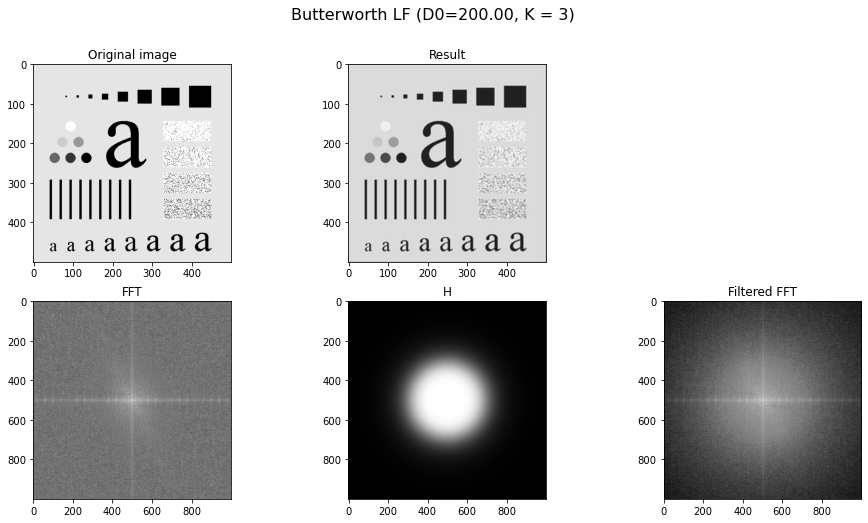

In [82]:
# Butterworth LF
plt.figure(figsize=(16, 8), constrained_layout=False)

d0 = 200
k = 3
plt.gcf().suptitle(f'Butterworth LF (D0={d0:.2f}, K = {k})', fontsize=16)
res = dftfilt(img1, butter_lowpass(d0, k, pq))
plt.subplot(231), plt.imshow(img1), plt.title("Original image")
plt.subplot(232), plt.imshow(res[0]), plt.title("Result")
plt.subplot(234), plt.imshow(res[1]), plt.title("FFT")
plt.subplot(235), plt.imshow(res[2]), plt.title("H")
plt.subplot(236), plt.imshow(res[3]), plt.title("Filtered FFT")

(<AxesSubplot:title={'center':'d0 = 25, k = 3'}>,
 Text(0.5, 1.0, 'd0 = 25, k = 3'))

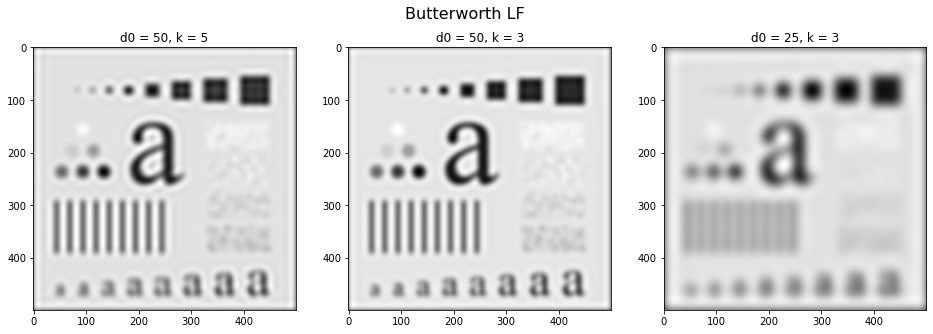

In [91]:
plt.figure(figsize=(16, 5), constrained_layout=False)

plt.gcf().suptitle(f'Butterworth LF', fontsize=16)
O,_,_,_ = dftfilt(img1, butter_lowpass(50, 5, pq))
plt.subplot(131), plt.imshow(O), plt.title("d0 = 50, k = 5")
O,_,_,_ = dftfilt(img1, butter_lowpass(50, 3, pq))
plt.subplot(132), plt.imshow(O), plt.title("d0 = 50, k = 3")
O,_,_,_ = dftfilt(img1, butter_lowpass(25, 3, pq))
plt.subplot(133), plt.imshow(O), plt.title("d0 = 25, k = 3")

(<AxesSubplot:title={'center':'Filtered FFT'}>,
 Text(0.5, 1.0, 'Filtered FFT'))

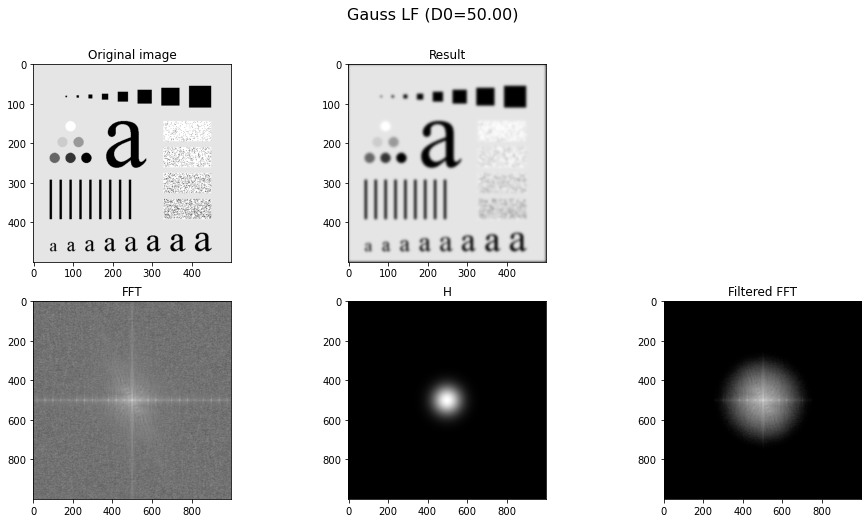

In [94]:
# Gauss LF
plt.figure(figsize=(16, 8), constrained_layout=False)

d0 = 50
plt.gcf().suptitle(f'Gauss LF (D0={d0:.2f})', fontsize=16)
res = dftfilt(img1, gauss_lowpass(d0, pq))
plt.subplot(231), plt.imshow(img1), plt.title("Original image")
plt.subplot(232), plt.imshow(res[0]), plt.title("Result")
plt.subplot(234), plt.imshow(res[1]), plt.title("FFT")
plt.subplot(235), plt.imshow(res[2]), plt.title("H")
plt.subplot(236), plt.imshow(res[3]), plt.title("Filtered FFT")

(<AxesSubplot:title={'center':'d0 = 30'}>,
 Text(0.5, 1.0, 'd0 = 30'))

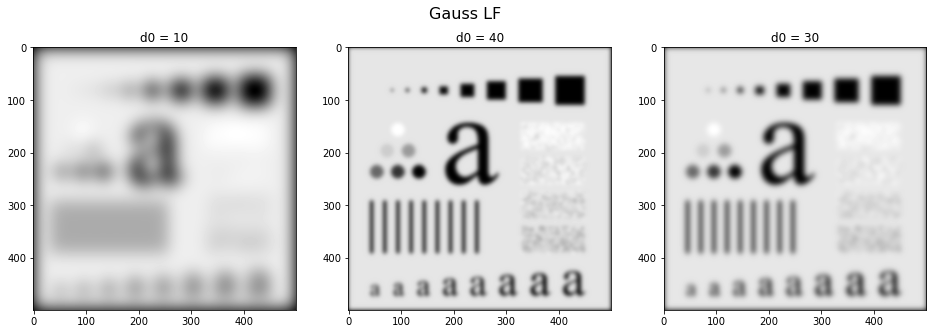

In [96]:
plt.figure(figsize=(16, 5), constrained_layout=False)

plt.gcf().suptitle(f'Gauss LF', fontsize=16)
O,_,_,_ = dftfilt(img1, gauss_lowpass(10, pq))
plt.subplot(131), plt.imshow(O), plt.title("d0 = 10")
O,_,_,_ = dftfilt(img1, gauss_lowpass(40, pq))
plt.subplot(132), plt.imshow(O), plt.title("d0 = 40")
O,_,_,_ = dftfilt(img1, gauss_lowpass(30, pq))
plt.subplot(133), plt.imshow(O), plt.title("d0 = 30")

### 2.2. Високочастотні фільтри

(<AxesSubplot:title={'center':'Filtered FFT'}>,
 Text(0.5, 1.0, 'Filtered FFT'))

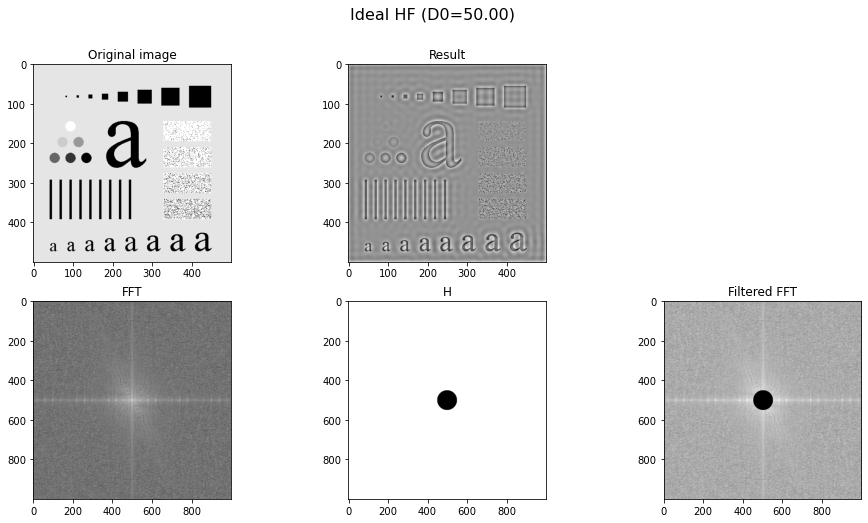

In [101]:
# HF filters
plt.figure(figsize=(16, 8), constrained_layout=False)

d0 = 50
plt.gcf().suptitle(f'Ideal HF (D0={d0:.2f})', fontsize=16)
res = dftfilt(img1, ideal_highpass(d0, pq))
plt.subplot(231), plt.imshow(img1), plt.title("Original image")
plt.subplot(232), plt.imshow(res[0]), plt.title("Result")
plt.subplot(234), plt.imshow(res[1]), plt.title("FFT")
plt.subplot(235), plt.imshow(res[2]), plt.title("H")
plt.subplot(236), plt.imshow(res[3]), plt.title("Filtered FFT")



(<AxesSubplot:title={'center':'d0 = 10'}>,
 Text(0.5, 1.0, 'd0 = 10'))

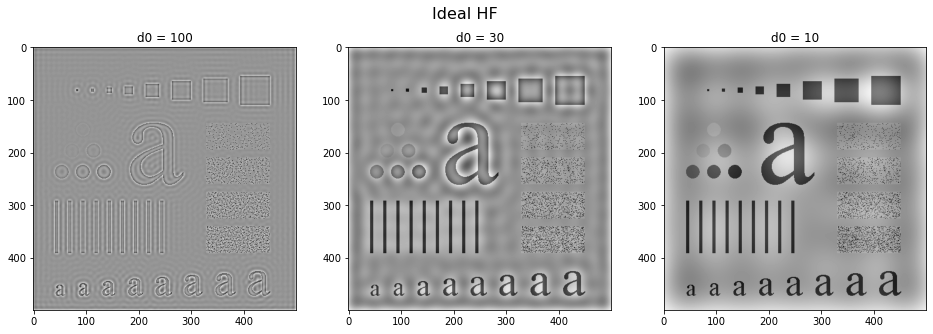

In [107]:
plt.figure(figsize=(16, 5), constrained_layout=False)

plt.gcf().suptitle(f'Ideal HF', fontsize=16)
O,_,_,_ = dftfilt(img1, ideal_highpass(100, pq))
plt.subplot(131), plt.imshow(O), plt.title("d0 = 100")
O,_,_,_ = dftfilt(img1, ideal_highpass(30, pq))
plt.subplot(132), plt.imshow(O), plt.title("d0 = 30")
O,_,_,_ = dftfilt(img1, ideal_highpass(10, pq))
plt.subplot(133), plt.imshow(O), plt.title("d0 = 10")

C:\Users\mkrooted\AppData\Local\Temp\ipykernel_5828\1264925807.py:40: RuntimeWarning: divide by zero encountered in true_divide
  H = np.float_power(1 + np.float_power( d02 / D2 , K), -1)


(<AxesSubplot:title={'center':'Filtered FFT'}>,
 Text(0.5, 1.0, 'Filtered FFT'))

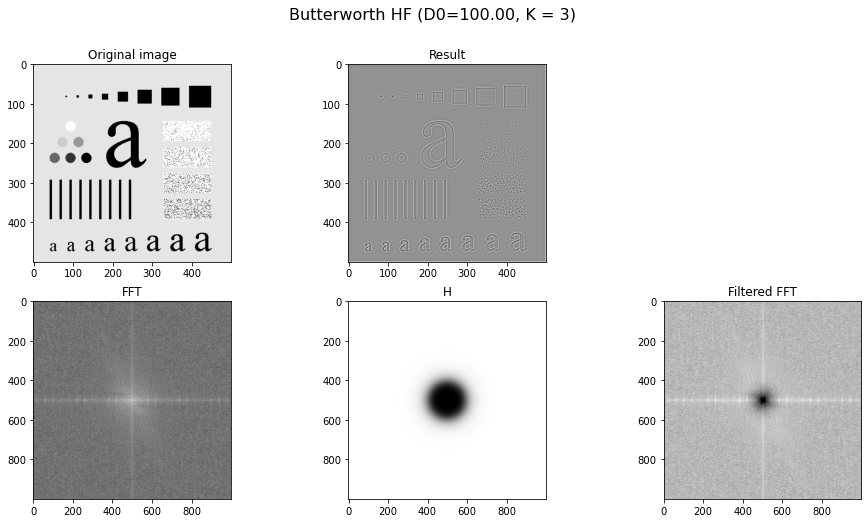

In [113]:
# Butterworth HF
plt.figure(figsize=(16, 8), constrained_layout=False)

d0 = 100
k = 3
plt.gcf().suptitle(f'Butterworth HF (D0={d0:.2f}, K = {k})', fontsize=16)
res = dftfilt(img1, butter_highpass(d0, k, pq))
plt.subplot(231), plt.imshow(img1), plt.title("Original image")
plt.subplot(232), plt.imshow(res[0]), plt.title("Result")
plt.subplot(234), plt.imshow(res[1]), plt.title("FFT")
plt.subplot(235), plt.imshow(res[2]), plt.title("H")
plt.subplot(236), plt.imshow(res[3]), plt.title("Filtered FFT")

C:\Users\mkrooted\AppData\Local\Temp\ipykernel_5828\1264925807.py:40: RuntimeWarning: divide by zero encountered in true_divide
  H = np.float_power(1 + np.float_power( d02 / D2 , K), -1)


(<AxesSubplot:title={'center':'d0 = 25, k = 3'}>,
 Text(0.5, 1.0, 'd0 = 25, k = 3'))

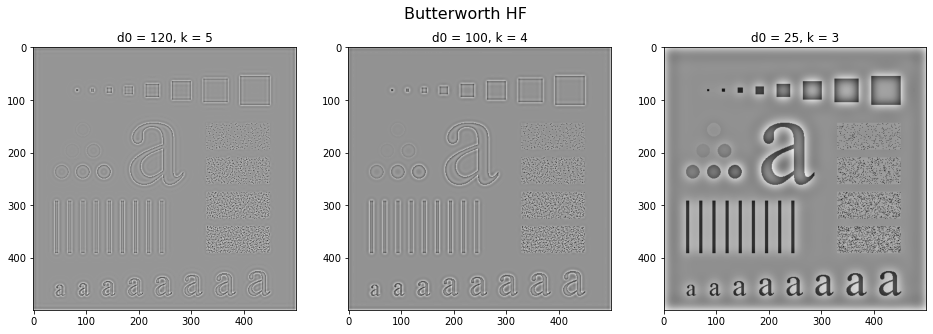

In [119]:
plt.figure(figsize=(16, 5), constrained_layout=False)

plt.gcf().suptitle(f'Butterworth HF', fontsize=16)
O,_,_,_ = dftfilt(img1, butter_highpass(120, 5, pq))
plt.subplot(131), plt.imshow(O), plt.title("d0 = 120, k = 5")
O,_,_,_ = dftfilt(img1, butter_highpass(100, 4, pq))
plt.subplot(132), plt.imshow(O), plt.title("d0 = 100, k = 4")
O,_,_,_ = dftfilt(img1, butter_highpass(25, 3, pq))
plt.subplot(133), plt.imshow(O), plt.title("d0 = 25, k = 3")

(<AxesSubplot:title={'center':'Filtered FFT'}>,
 Text(0.5, 1.0, 'Filtered FFT'))

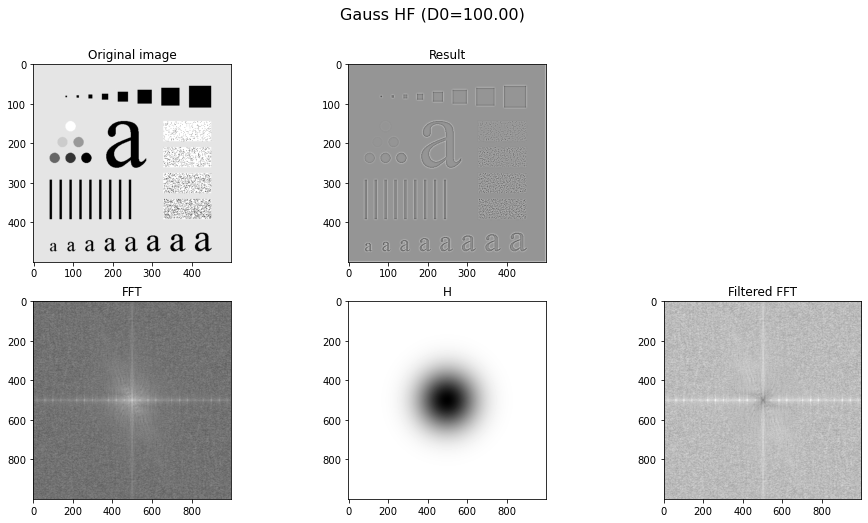

In [123]:
# Gauss HF
plt.figure(figsize=(16, 8), constrained_layout=False)

d0 = 100
plt.gcf().suptitle(f'Gauss HF (D0={d0:.2f})', fontsize=16)
res = dftfilt(img1, gauss_highpass(d0, pq))
plt.subplot(231), plt.imshow(img1), plt.title("Original image")
plt.subplot(232), plt.imshow(res[0]), plt.title("Result")
plt.subplot(234), plt.imshow(res[1]), plt.title("FFT")
plt.subplot(235), plt.imshow(res[2]), plt.title("H")
plt.subplot(236), plt.imshow(res[3]), plt.title("Filtered FFT")

(<AxesSubplot:title={'center':'d0 = 100'}>,
 Text(0.5, 1.0, 'd0 = 100'))

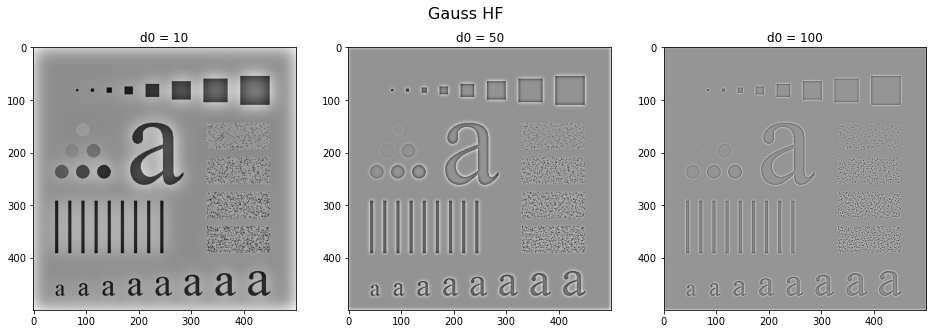

In [129]:
plt.figure(figsize=(16, 5), constrained_layout=False)

plt.gcf().suptitle(f'Gauss HF', fontsize=16)
O,_,_,_ = dftfilt(img1, gauss_highpass(10, pq))
plt.subplot(131), plt.imshow(O), plt.title("d0 = 10")
O,_,_,_ = dftfilt(img1, gauss_highpass(50, pq))
plt.subplot(132), plt.imshow(O), plt.title("d0 = 50")
O,_,_,_ = dftfilt(img1, gauss_highpass(100, pq))
plt.subplot(133), plt.imshow(O), plt.title("d0 = 100")

(<AxesSubplot:title={'center':'Filtered FFT'}>,
 Text(0.5, 1.0, 'Filtered FFT'))

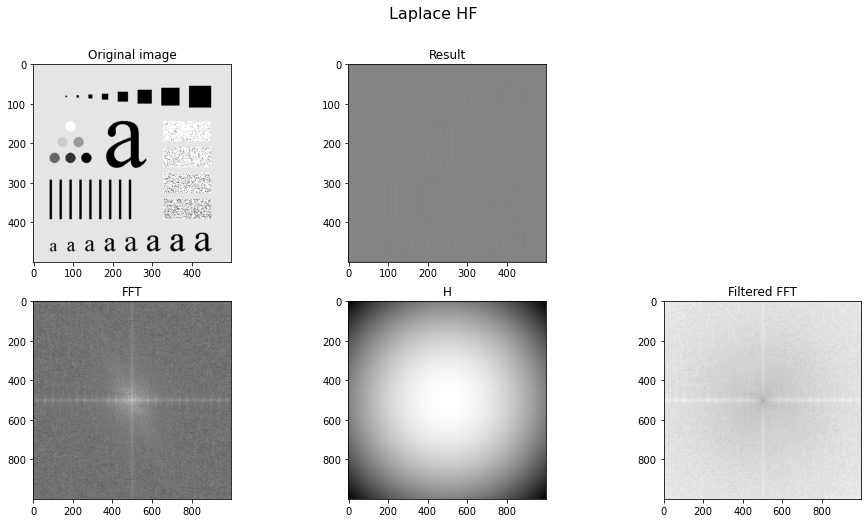

In [151]:
# Laplace
plt.figure(figsize=(16, 8), constrained_layout=False)

plt.gcf().suptitle(f'Laplace HF', fontsize=16)
res = dftfilt(img1, laplace_highpass(pq))
plt.subplot(231), plt.imshow(img1), plt.title("Original image")
plt.subplot(232), plt.imshow(res[0]), plt.title("Result")
plt.subplot(234), plt.imshow(res[1]), plt.title("FFT")
plt.subplot(235), plt.imshow(res[2]), plt.title("H")
plt.subplot(236), plt.imshow(res[3]), plt.title("Filtered FFT")

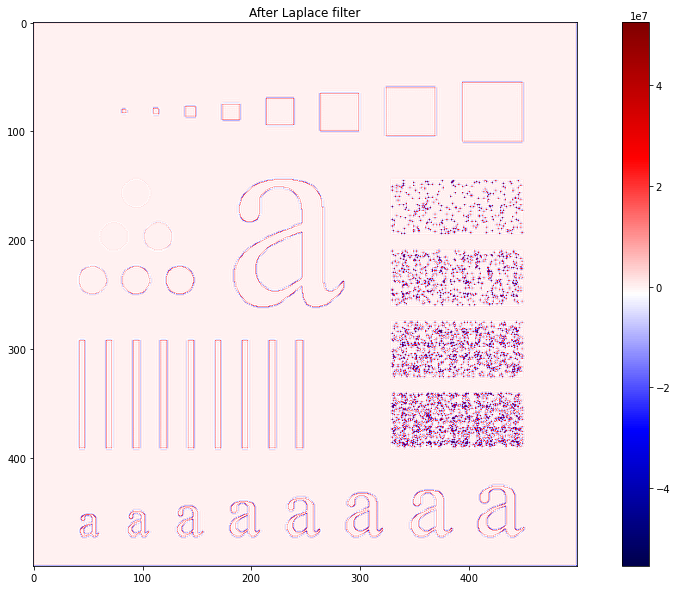

In [166]:
plt.figure(figsize=(16, 10), constrained_layout=False)
plt.title("After Laplace filter")
plt.imshow(res[0], cmap='seismic')
plt.colorbar()

## 3. Друге зображення

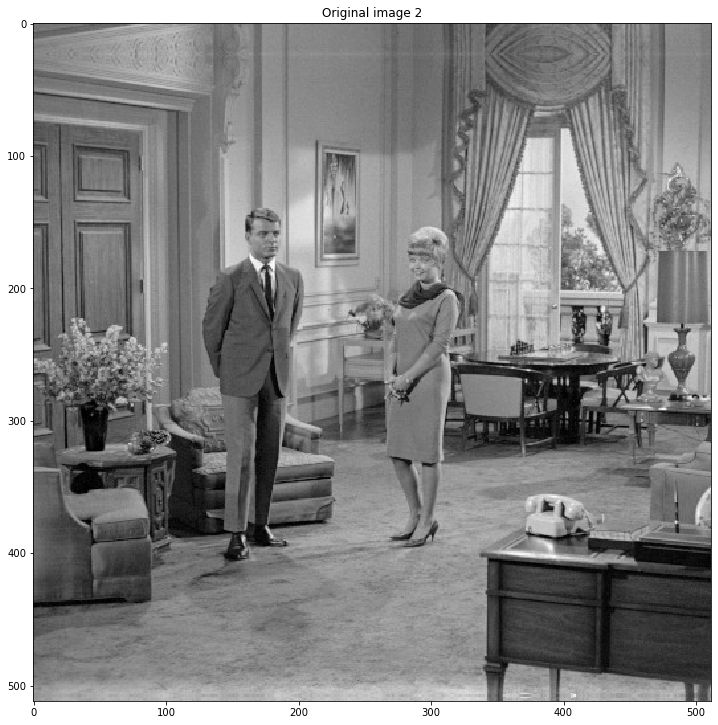

In [170]:
img2 = ski.io.imread('Pic2.jpg')
plt.figure(figsize=(10,10))
ski.io.imshow(img2)
plt.title("Original image 2")

pq2 = paddedsize(img2.shape)

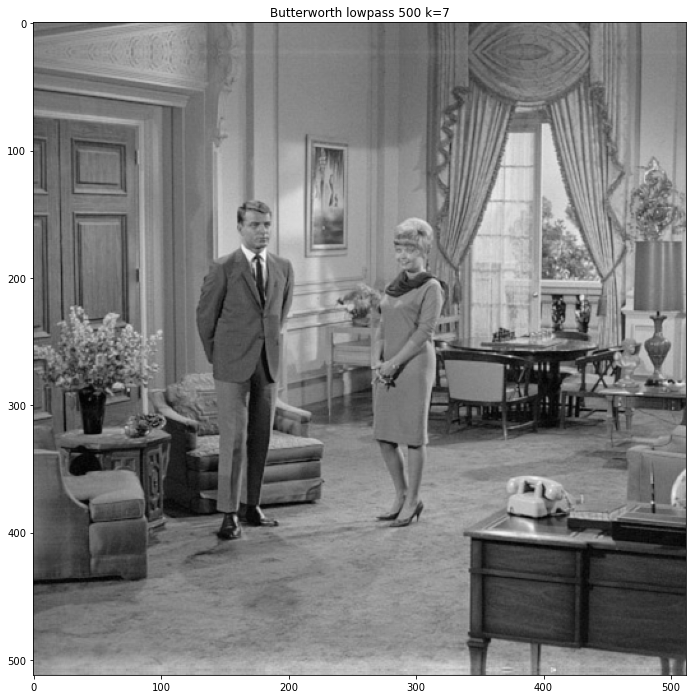

In [195]:
d = 500
res = dftfilt(img2, butter_lowpass(d, 7, pq2))

plt.figure(figsize=(12,12))
plt.title(f"Butterworth lowpass {d} k=7")
plt.imshow(res[0])

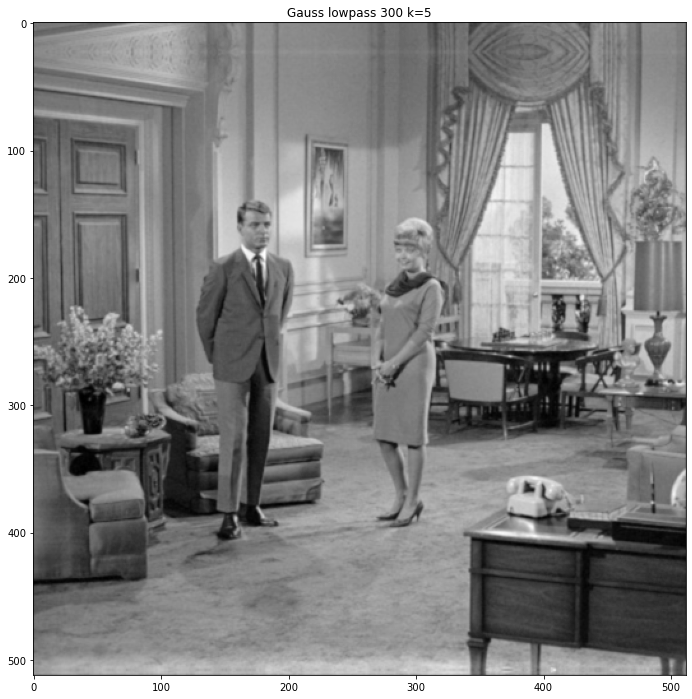

In [194]:
d = 300
res = dftfilt(img2, gauss_lowpass(d, pq2))

plt.figure(figsize=(12,12))
plt.title(f"Gauss lowpass {d} k=5")
plt.imshow(res[0])

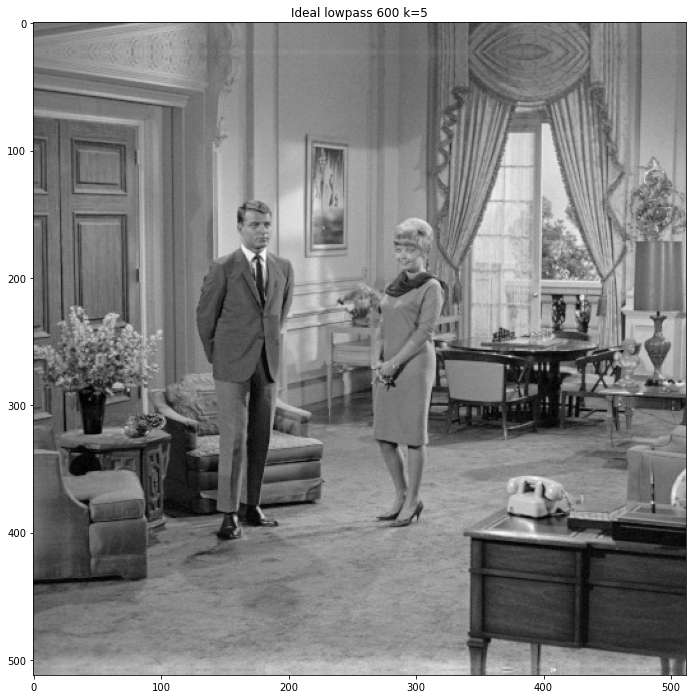

In [198]:
d = 600
res = dftfilt(img2, ideal_lowpass(d, pq2))

plt.figure(figsize=(12,12))
plt.title(f"Ideal lowpass {d} k=5")
plt.imshow(res[0])

## 4. Питання

> На чому основана фільтрація зображень в частотній області

З одного боку, в принципі на існуванні алгоритмів швидкого дискретного перетворення Фур'є (і оберненого). З іншого боку, тут грає роль той факт, що для фільтрів також можна будувати їх частотний образ (передатну функцію) та застосовувати в частотній області. Для деяких класів задач фільтрування в частотній області ще й буде ефективнішим, ніж в просторовій, бо останнє включає в себе складну операцію згортки, а перше - лише поелементне множення.

> Як на перетвореному зображенні-образі розташовані частоти.

- Частотний образ буде симетричним відносно осей X та Y
- Коефіцієнти низьких частот будуть ближче до нуля зображення (нуль зазвичай розташовано у верхньому лівому куті). Високих частот - ближче до центру зображення.
- Часто квадранти міняють місцями по діагоналі (fftshift2). Таким чином матимемо більш явну та наочну симетрію та простіший вигляж деяких формул

> Навіщо потрібне розширення зображень paddedsize.

Якщо виконувати FFT зображення без полів, то отриманий частотний образ буде відповідати нескінченному замощенню оригінального зображення по вертикалі та горизонталі. Іноді це призводить до не корисних результатів. Щоб "підкреслити" для FFT границі зображення, ми додаємо поля розміром в саме зображення з усіх боків. Неформально, такий розмір полів пов'язаний із тим, що у дискретному перетворенні будуть максимальні та мінімальні можливі частоти; поля такого розміру будуть більші, ніж довжина хвилі найнижчої частоти.

> Що таке ефект «дзвону». Коли він виникає

Найкраще цей ефект продемонстровано у перших результатах низькочастотного фільтрування. Цей ефект виглядає як хвилі від границь об'єктів на зображені. Він пов'язаний із тим, що прибирання високих частоти занадто різко еквівалентно зменшенню кількості членів у розкладі зображення в ряд фур'є. З цього з'являються неточності представлення та хвильоподібні артефакти у вигляді ефекту "дзвону". 

> Як перейти від НЧ-фільту до відповідного ВЧ-фільтру і навпаки.

Головна ідея: треба відобразити функцію фільтра відносно осі значень та зсунути екстремум до одиниці (у випадку переходу ВЧ->НЧ) чи нуля (у випадку НЧ->ВЧ)

> Який вид фільтрації – частотна чи просторова є більш ефективною і коли

Відповідь великою мірою залежить від розміру зображень. Для достатньо великих зображень частотна фільтрація вимагає суттєво менше операцій, ніж просторова. Але FFT - складний алгоритм, і накладні витрати на нього достатньо великі, щоб для малих зображень згортка працювала швидше.
